In [1]:
from IPython.display import display
from math import ceil, sqrt
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

# from statsmodels.tsa.seasonal import seasonal_decompose
# from pandas.plotting import lag_plot
# from statsmodels.tsa.stattools import adfuller

# colors generator
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# # Algorithms
# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances_argmin_min
# from sklearn.decomposition import PCA
# from tslearn.barycenters import dtw_barycenter_averaging

# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
# from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.arima.utils import nsdiffs
from pmdarima.arima.utils import ndiffs
from pmdarima.utils import diff_inv
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import pearsonr
from sklearn.model_selection import ParameterGrid

from autots import AutoTS

import joblib
import random
random.seed(7)
np.random.seed(7)
print("setup complete")

setup complete


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def excess_short(forecast, actual):
    epsilon = forecast - actual
    mape = np.mean(np.abs(epsilon)/np.abs(actual))
    exces_mask = epsilon>0
    short_mask = epsilon<0
    mape_exces = np.sum(np.abs(forecast[exces_mask] - actual[exces_mask])/np.abs(actual[exces_mask]))/len(forecast)
    mape_short = np.sum(np.abs(forecast[short_mask] - actual[short_mask])/np.abs(actual[short_mask]))/len(forecast)
    return 100*mape_exces/mape, 100*mape_short/mape

In [4]:
def forecast_accuracy(forecast, actual):
    assert len(forecast) == len(actual)
    mape = mean_absolute_percentage_error(actual, forecast)*100
    mae = mean_absolute_error(actual, forecast)   # MAE
    rmse = mean_squared_error(actual, forecast, squared=True)  # RMSE
    mape_exces, mape_short = excess_short(forecast, actual)
    return pd.Series({'mape':mape, 'mae': mae, 'rmse':rmse, 'mape_exces':mape_exces,'mape_short':mape_short})

In [5]:
sales = pd.read_csv('70prod_data.csv',\
                    index_col=0, parse_dates=True)

In [6]:
def choose_d(l):
    return list(sorted(l))[1]
def Oui_non(x): 
    return "Oui" if x else "Non"
def test_all(y):
    y = y.dropna()
    n_ch = nsdiffs(remove_trend(y)["serie"].dropna(), m=12, max_D=12, test='ch')
    n_ocsb = nsdiffs(remove_trend(y)["serie"].dropna(), m=12, max_D=12, test='ocsb')
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')
    return (Oui_non(n_ch), Oui_non(n_ocsb), max(n_ch, n_ocsb), Oui_non(n_adf), \
            Oui_non(n_kpss), Oui_non(n_pp), choose_d((n_adf, n_kpss, n_pp)))
def multiple_test_all(df):
    res = pd.DataFrame(df.columns, columns=["Series"])
    res[1], res[2], res[3], res[4], res[5], res[6], res[7] = [[test_all(df[i])[j]\
                                               for i in df.columns] for j in range(7)]
    res=res.set_index("Series")
    res.columns = ["Canova-Hansen", "OCSB", "Seasonality Order", "ADF", "KPSS", "PP", "differencing order"]
    return res

In [7]:
def remove_trend(y):
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')
    n_diff=max(n_adf, n_kpss, n_pp)
    for i in range(n_diff):
        y = y.diff(1)
    return {"serie" : y, "n_diff" : n_diff}
def stationnarise(y):
    y ,n_diff = remove_trend(y).values()
    y = y.dropna()
    n_ch = nsdiffs(y, m=12, max_D=12, test='ch')
    n_ocsb = nsdiffs(y, m=12, max_D=12, test='ocsb')
    n_sdiff=max(n_ch, n_ocsb)
    for i in range(n_sdiff):
        y = y.diff(12)
    return {"serie" : y, "n_diff" : n_diff, "n_sdiff" : n_sdiff}

In [8]:
def series_from_summary(summary):
    return pd.DataFrame([dic['serie'] for dic in summary.values()]).T

def orders_from_summary(summary):
    return [(dic["n_diff"], dic["n_sdiff"]) for dic in summary.values()]

In [9]:
def diff_inv_wrapper(train, diff_test, lags=1, differences=1):
    last_train = train[-lags:]
    added_orig = pd.concat([last_train, diff_test])
    X_diff_inv = diff_test.copy()
    X_diff_inv.iloc[:, 0] = diff_inv(added_orig, lag=lags, differences=differences)[-len(diff_test):]
    return X_diff_inv

In [10]:
def undiff_d1_D1(train, diff_test):
    diff_train_s = train.diff(1)[-12:]
    unseasonal_test = diff_inv_wrapper(diff_train_s, diff_test, lags=12)
    return diff_inv_wrapper(train, unseasonal_test, lags=1)

In [11]:
def invert_transformation(train, test, d=1, D=0):
    if d==1 and D==1 :
        return undiff_d1_D1(train, test)
    elif d==1 and D==0 :
        return diff_inv_wrapper(train, test)
    elif d==0 and D==1 :
        return diff_inv_wrapper(train, test, lags=12)
    elif d==0 and D==0 :
        return test
    else : 
        raise ValueError("unexpected case")

In [12]:
def excess_short(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    epsilon = forecast - actual
    exces_mask = epsilon>0
    short_mask = epsilon<0
    mape_exces = np.sum(np.abs(forecast[exces_mask] - actual[exces_mask])/np.abs(actual[exces_mask]))/len(forecast)
    mape_short = np.sum(np.abs(forecast[short_mask] - actual[short_mask])/np.abs(actual[short_mask]))/len(forecast)
    return 100*mape_exces/mape, 100*mape_short/mape

In [13]:
def remove_axes(n_used_axes, all_axs):
    if n_used_axes%2 :
        all_axs = all_axs.flatten()
        size = len(all_axs)
        for useless_ax in all_axs.flatten()[-(size - n_used_axes):]:
            useless_ax.axis('off')

In [14]:
joblib_Filename = "kmeans_labels.joblib"
labels = joblib.load(joblib_Filename)

In [15]:
cluster_count = len(np.unique(labels))
clusters = [[] for _ in range(cluster_count)]
for i, lab in enumerate(labels):
    clusters[lab].append(i)
clusters_n = ["cluster_"+str(i) for i in range(cluster_count)]
cluster_p = {}
for cluster, cluster_n in zip(clusters, clusters_n):
    cluster_p[cluster_n] = [sales.columns[p] for p in cluster]
# cluster_p

In [16]:
cluster_p

{'cluster_0': ['P_13', 'P_16', 'P_20', 'P_30', 'P_40'],
 'cluster_1': ['P_1', 'P_5', 'P_8', 'P_31', 'P_38', 'P_52', 'P_56', 'P_68'],
 'cluster_2': ['P_11',
  'P_12',
  'P_14',
  'P_41',
  'P_42',
  'P_43',
  'P_44',
  'P_45',
  'P_46',
  'P_47',
  'P_48',
  'P_49',
  'P_50'],
 'cluster_3': ['P_2', 'P_6', 'P_10', 'P_26'],
 'cluster_4': ['P_4',
  'P_7',
  'P_9',
  'P_28',
  'P_29',
  'P_33',
  'P_53',
  'P_54',
  'P_55',
  'P_57',
  'P_69'],
 'cluster_5': ['P_18', 'P_37', 'P_65', 'P_67'],
 'cluster_6': ['P_15',
  'P_17',
  'P_22',
  'P_32',
  'P_36',
  'P_60',
  'P_62',
  'P_63',
  'P_66',
  'P_70'],
 'cluster_7': ['P_3', 'P_21', 'P_23', 'P_24', 'P_25', 'P_27'],
 'cluster_8': ['P_19',
  'P_34',
  'P_35',
  'P_39',
  'P_51',
  'P_58',
  'P_59',
  'P_61',
  'P_64']}

In [17]:
cluster_7 = sales[cluster_p['cluster_7']]
cluster_7.head()

,P_3,P_21,P_23,P_24,P_25,P_27
2014-07-31,3506,16302,21457,7204,11457,12851
2014-08-31,3279,16907,22408,7477,12571,13270
2014-09-30,3238,16286,21252,7592,12643,12860
2014-10-31,3088,15147,20512,7435,13066,12857
2014-11-30,2921,15298,22433,7434,13917,15042


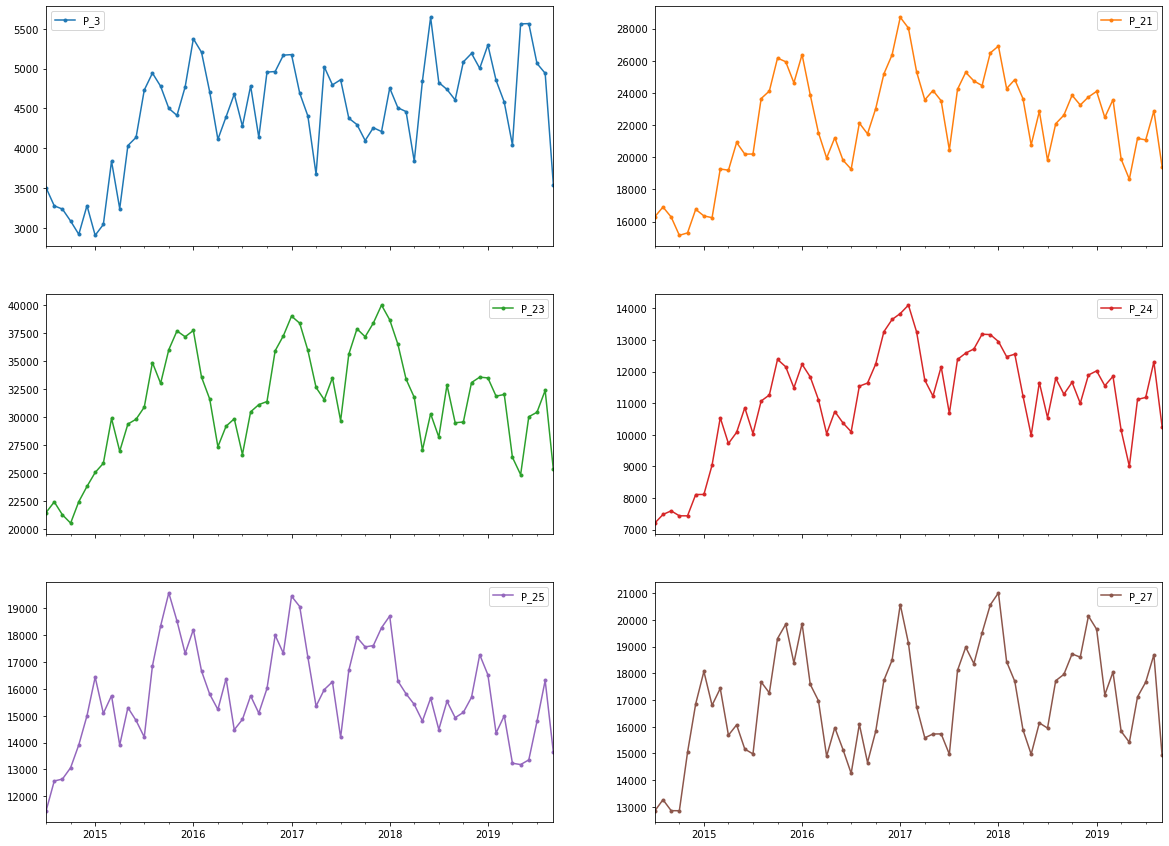

In [18]:
cluster_7.plot(subplots=True,layout=(3,2),figsize=(20,15), marker='.')
plt.show()

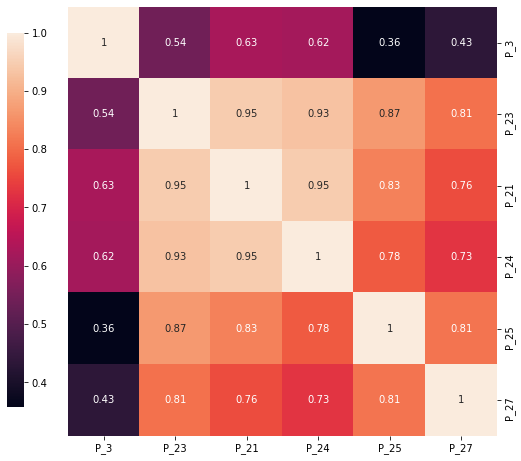

In [19]:
cg = sns.clustermap(cluster_7.corr(), figsize=(8, 8), cbar_pos=(.1, .1, .03, .65), annot=True)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
plt.show()

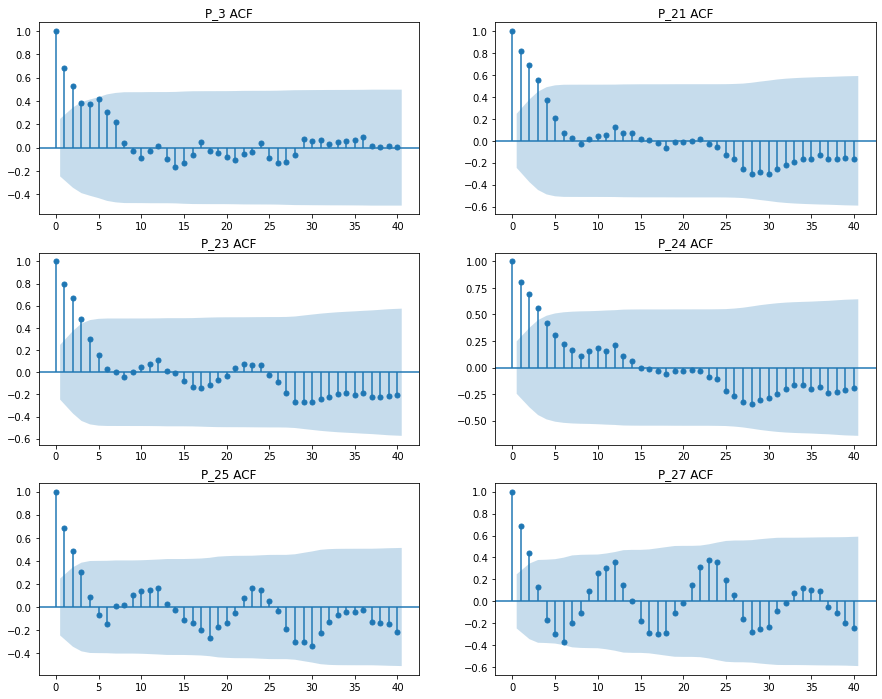

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=False)
remove_axes(len(cluster_7.columns), axes)
axs = axes.flatten()
alpha=.05
for i, col in enumerate(cluster_7.columns):
    sm.graphics.tsa.plot_acf(cluster_7[col].values.squeeze(), lags=40, ax=axs[i], title=f"{col} ACF", alpha=alpha)

In [21]:
multiple_test_all(cluster_7)

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_3,Non,Oui,1,Oui,Oui,Non,1
P_21,Non,Non,0,Oui,Oui,Oui,1
P_23,Non,Oui,1,Oui,Non,Oui,1
P_24,Non,Non,0,Oui,Oui,Oui,1
P_25,Non,Non,0,Non,Non,Oui,0
P_27,Non,Non,0,Non,Non,Non,0


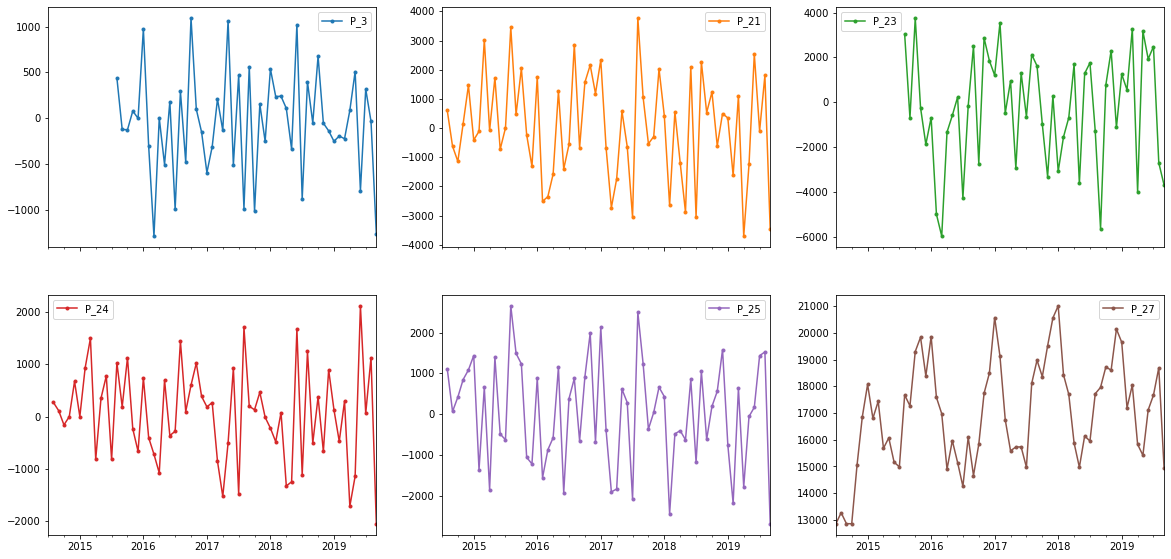

In [22]:
stationnarisation_summary  = {}
for col in cluster_7.columns:
    stationnarisation_summary[col] = stationnarise(cluster_7[col])
cluster_7_stat = series_from_summary(stationnarisation_summary)
orders_7 = orders_from_summary(stationnarisation_summary)
cluster_7_stat.plot(subplots=True,layout=(3,3),figsize=(20,15), marker='.')
plt.show()

In [23]:

train_var = cluster_7.loc[:'2018-12-31']
test_var = cluster_7.loc['2019-01-31':]



In [32]:
cluster_7_filename = "cluster_7_export.json"  # .csv/.json
best_model = AutoTS(frequency='M', max_generations=0,
               num_validations=0, verbose=0)
try :
    best_model = best_model.import_template(cluster_7_filename, method='only',enforce_model_list=False)
    print("template found and imported")
except Exception :
    print("template not found", "Fitting new models ...", sep='\n')
    model = AutoTS(
    forecast_length=len(test_var),
    frequency='M',
    prediction_interval=0.95,
    model_list=["VARMAX"],
    ensemble="all",
	# transformer_list="fast",
    max_generations=8,
    num_validations=2,
    # models_to_validate=0.2, 
    validation_method="backwards"
    )
    model.fit(train_var)
    model.export_template(cluster_7_filename, models='best', n=1)
    best_model = best_model.import_template(cluster_7_filename, method='only',enforce_model_list=False)
    print("models fitted and ready to predict", "template is saved to "+cluster_7_filename, sep='\n')

template not found
Fitting new models ...
Model Number: 1 with model VARMAX in generation 0 of 8
Model Number: 2 with model VARMAX in generation 0 of 8
Model Number: 3 with model VARMAX in generation 0 of 8
Model Number: 4 with model VARMAX in generation 0 of 8
Model Number: 5 with model VARMAX in generation 0 of 8
Model Number: 6 with model VARMAX in generation 0 of 8
Model Number: 7 with model VARMAX in generation 0 of 8
Model Number: 8 with model VARMAX in generation 0 of 8
Model Number: 9 with model VARMAX in generation 0 of 8
Model Number: 10 with model VARMAX in generation 0 of 8
Model Number: 11 with model VARMAX in generation 0 of 8
Model Number: 12 with model VARMAX in generation 0 of 8
Model Number: 13 with model VARMAX in generation 0 of 8
Model Number: 14 with model VARMAX in generation 0 of 8
Model Number: 15 with model VARMAX in generation 0 of 8
Model Number: 16 with model VARMAX in generation 0 of 8
Model Number: 17 with model VARMAX in generation 0 of 8
Model Number: 1

In [33]:
best_model.fit(train_var)

Initiated AutoTS object with best model: 
Ensemble
{}
{"model_name": "Horizontal", "model_count": 3, "model_metric": "MAE", "models": {"e39d16904bb84d85bdf056da0c07397e": {"Model": "Ensemble", "ModelParameters": "{\"model_name\": \"BestN\", \"model_count\": 3, \"model_metric\": \"horizontal\", \"models\": {\"28343cdab29df1147649502feee787bd\": {\"Model\": \"VARMAX\", \"ModelParameters\": \"{\\\"order\\\": [2, 0], \\\"trend\\\": \\\"c\\\"}\", \"TransformationParameters\": \"{\\\"fillna\\\": \\\"zero\\\", \\\"transformations\\\": {\\\"0\\\": \\\"ClipOutliers\\\", \\\"1\\\": \\\"SeasonalDifference\\\"}, \\\"transformation_params\\\": {\\\"0\\\": {\\\"method\\\": \\\"clip\\\", \\\"std_threshold\\\": 3.5, \\\"fillna\\\": null}, \\\"1\\\": {\\\"lag_1\\\": 12, \\\"method\\\": \\\"LastValue\\\"}}}\"}, \"8c41e7b7c647fa3d5404a9f9f8168095\": {\"Model\": \"VARMAX\", \"ModelParameters\": \"{\\\"order\\\": [2, 0], \\\"trend\\\": \\\"c\\\"}\", \"TransformationParameters\": \"{\\\"fillna\\\": \\\"medi

In [34]:
prediction=best_model.predict(forecast_length=len(test_var))
forecast_cluster_7=prediction.forecast
lower_forecast_cluster_7=prediction.lower_forecast
upper_forecast_cluster_7=prediction.upper_forecast


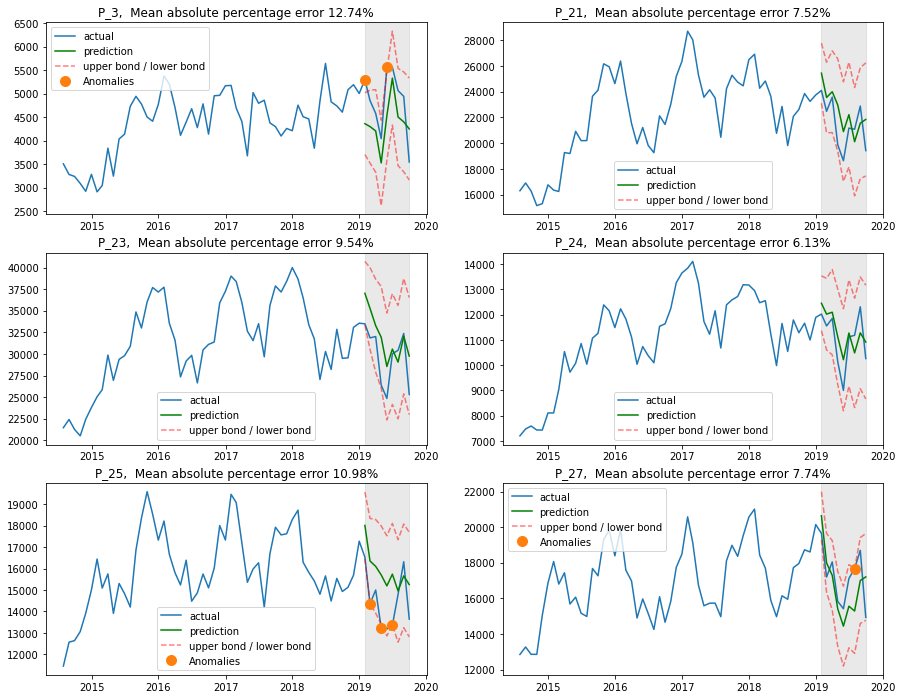

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=False)
remove_axes(len(forecast_cluster_7.columns), axes)
axs = axes.flatten()
alpha=.05
accuracies = pd.DataFrame(columns=cluster_7.columns, index=['mape', 'mae', 'rmse','mape_exces','mape_short'])
for i, col in enumerate(forecast_cluster_7.columns):
    axs[i].plot(cluster_7[col],label="actual")
    axs[i].plot(forecast_cluster_7[col],'g',label="prediction")
    axs[i].plot(lower_forecast_cluster_7[col], "r--", label="upper bond / lower bond", alpha=0.5)
    axs[i].plot(upper_forecast_cluster_7[col], "r--", alpha=0.5)
    accuracies[col] = forecast_accuracy(forecast_cluster_7[col], test_var[col])
    axs[i].set_title(f"{col},  Mean absolute percentage error {accuracies[col]['mape']:.2f}%")
    axs[i].axvspan(forecast_cluster_7.index[0], forecast_cluster_7.index[-1],  color=sns.xkcd_rgb['grey'], alpha=0.2)
   

    anomalies = np.array([np.NaN]*len(test_var))
    anomalies[test_var[col]<lower_forecast_cluster_7[col]] = test_var[col][test_var[col]<lower_forecast_cluster_7[col]]
    anomalies[test_var[col]>upper_forecast_cluster_7[col]] = test_var[col][test_var[col]>upper_forecast_cluster_7[col]]
    anomalies_series = pd.Series(anomalies, index=forecast_cluster_7.index)
    if ~np.isnan(anomalies).all() : axs[i].plot(anomalies_series, "o", markersize=10, label = "Anomalies")
    axs[i].legend(loc="best")

In [30]:
accuracies

,P_3,P_21,P_23,P_24,P_25,P_27
mape,10.929292,9.913910e+00,9.968989e+00,7.540001,1.049337e+01,7.545002e+00
mae,515.731117,2.077667e+03,2.880241e+03,814.088681,1.490444e+03,1.287188e+03
rmse,310551.721816,5.191297e+06,1.186297e+07,704365.960926,2.694815e+06,2.125985e+06
mape_exces,20.028652,8.937790e+01,9.187367e+01,85.330607,9.280129e+01,4.362475e+01
mape_short,79.971348,1.062210e+01,8.126330e+00,14.669393,7.198705e+00,5.637525e+01
